Backtest da Estratégia de Máximas e Mínimas.

Fonte: https://quantbrasil.com.br/backtest-da-estrategia-de-maximas-e-minimas/

In [134]:
%%capture

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import floor

%pip install yfinance
import yfinance as yf

import warnings
warnings.filterwarnings('ignore')

In [135]:
ticker = 'BPAC11.SA'
start = '2023-04-03'
end = '2023-08-03'
df = yf.download(ticker, start, end)[["Open", "High", "Low", "Close"]]

# Define backtest parameters
initial_capital = 10000
total_capital = [initial_capital] # list with the total capital after every operation
all_profits = [] # list with the results of every operation
ongoing = False

use_mme_21 = True

[*********************100%%**********************]  1 of 1 completed


In [136]:
df['MME21'] = df["Close"].ewm(span=21).mean()
df["Variation 21"] = df["MME21"].pct_change()

In [137]:
df["Target1"] = df["High"].shift(1)
df["Target2"] = df["High"].shift(2)
df["Target"] = df[["Target1", "Target2"]].max(axis=1)

# We don't need them anymore
df.drop(columns=["Target1", "Target2"], inplace=True)

df.head()

,Open,High,Low,Close,MME21,Variation 21,Target
Date,,,,,,,
2023-04-03,19.650000,19.719999,19.370001,19.639999,19.639999,NaN,NaN
2023-04-04,19.770000,20.459999,19.620001,20.219999,19.943809,0.015469,19.719999
2023-04-05,20.290001,20.850000,20.010000,20.570000,20.172719,0.011478,20.459999
2023-04-06,20.430000,20.760000,20.180000,20.450001,20.252241,0.003942,20.850000
2023-04-10,20.360001,21.040001,20.340000,20.850000,20.395593,0.007078,20.850000


In [138]:
df["Entry1"] = df["Low"].shift(1)
df["Entry2"] = df["Low"].shift(2)
df["Entry"] = df[["Entry1", "Entry2"]].min(axis=1)

# We don't need them anymore
df.drop(columns=["Entry1", "Entry2"], inplace=True)

df.head()

,Open,High,Low,Close,MME21,Variation 21,Target,Entry
Date,,,,,,,,
2023-04-03,19.650000,19.719999,19.370001,19.639999,19.639999,NaN,NaN,NaN
2023-04-04,19.770000,20.459999,19.620001,20.219999,19.943809,0.015469,19.719999,19.370001
2023-04-05,20.290001,20.850000,20.010000,20.570000,20.172719,0.011478,20.459999,19.370001
2023-04-06,20.430000,20.760000,20.180000,20.450001,20.252241,0.003942,20.850000,19.620001
2023-04-10,20.360001,21.040001,20.340000,20.850000,20.395593,0.007078,20.850000,20.010000


In [139]:
condition_1 = df["Variation 21"].shift(1) > 0
condition_2 = df["Close"].shift(1) > df["MME21"].shift(1)
condition_3 = df["Low"] < df['Entry']

all_conditions = condition_1 & condition_2 & condition_3 if use_mme_21 else condition_3

# Define exact buy price
df['Buy Price'] = np.where(
    all_conditions,
    np.where((df['Open'] < df['Entry']), df['Open'], df['Entry']),
    np.nan)

# Define exact sell price
df['Sell Price'] = np.where(
    df["High"] > df['Target'], 
    np.where(df['Open'] > df['Target'], df['Open'], df['Target']),
    np.nan)

df.head(10)

,Open,High,Low,Close,MME21,Variation 21,Target,Entry,Buy Price,Sell Price
Date,,,,,,,,,,
2023-04-03,19.650000,19.719999,19.370001,19.639999,19.639999,NaN,NaN,NaN,NaN,NaN
2023-04-04,19.770000,20.459999,19.620001,20.219999,19.943809,0.015469,19.719999,19.370001,NaN,19.770000
2023-04-05,20.290001,20.850000,20.010000,20.570000,20.172719,0.011478,20.459999,19.370001,NaN,20.459999
2023-04-06,20.430000,20.760000,20.180000,20.450001,20.252241,0.003942,20.850000,19.620001,NaN,NaN
2023-04-10,20.360001,21.040001,20.340000,20.850000,20.395593,0.007078,20.850000,20.010000,NaN,20.850000
2023-04-11,21.200001,22.850000,21.200001,22.600000,20.855728,0.022560,21.040001,20.180000,NaN,21.200001
2023-04-12,22.620001,23.740000,22.549999,23.160000,21.286010,0.020631,22.850000,20.340000,NaN,22.850000
2023-04-13,23.170000,23.520000,22.740000,23.010000,21.579784,0.013801,23.740000,21.200001,NaN,NaN
2023-04-14,22.900000,23.299999,22.760000,22.950001,21.796080,0.010023,23.740000,22.549999,NaN,NaN


In [140]:
# Create a function to round any number to the smalles multiple of 100
def round_down(x):
  return int(floor(x / 100.0)) * 100

In [141]:
# Define control variable for ongoing operations
ongoing = False

for i in range(0, len(df)):

    # If there is an ongoing operation, check if we reached the target price
    if ongoing == True:
        if ~(np.isnan(df["Sell Price"][i])):

            # Define exit point and total profit
            exit = df["Sell Price"][i]
            taxes = (0.000325 * shares * entry) + (0.000325 * shares * exit)

            profit = (shares * (exit - entry)) - taxes

            # Append profit to list and create a new entry with the capital
            # after the operation is complete
            all_profits += [profit]
            current_capital = total_capital[-1]  # current capital is the last entry in the list
            total_capital += [current_capital + profit]
            ongoing = False

    # If there is no ongoing operation, check if the entry price was achieved
    else:
        if ~(np.isnan(df["Buy Price"][i])):
            entry = df["Buy Price"][i]
            shares = round_down(initial_capital / entry)
            ongoing = True

In [142]:
def strategy_test(all_profits): 
  num_operations = len(all_profits)
  gains = sum(x >= 0 for x in all_profits)
  pct_gains = 100 * (gains / num_operations)
  losses = num_operations - gains
  pct_losses = 100 - pct_gains

  print("Number of operations =", num_operations)
  print("Number of gains =", gains, "or", pct_gains.round(), "%")
  print("Number of loss =", losses, "or", pct_losses.round(), "%")
  print("The total profit was = R$", sum(all_profits).round(2), f"({((sum(all_profits)/initial_capital)*100).round(2)}%)")

strategy_test(all_profits)

Number of operations = 7
Number of gains = 7 or 100.0 %
Number of loss = 0 or 0.0 %
The total profit was = R$ 1314.89 (13.15%)


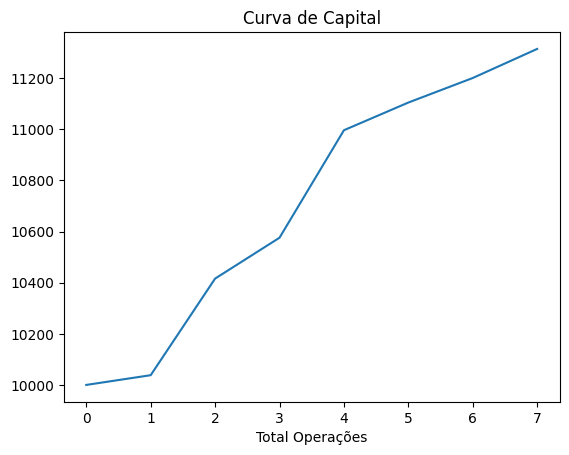

In [143]:
def capital_plot(total_capital, all_profits):
  all_profits = [0] + all_profits # make sure both lists are the same size
  cap_evolution = pd.DataFrame({'Capital': total_capital, 'Profit': all_profits})
  plt.title("Curva de Capital")
  plt.xlabel("Total Operações")
  cap_evolution['Capital'].plot()

capital_plot(total_capital, all_profits)